In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [2]:
#df_pe_original = pd.read_csv('DKA - Physical.csv')
df_pe_original = pd.read_csv('PHYSEXAM.csv')

df_pe_original.head()

pd.set_option('display.max_columns', None) # View max columns
print(df_pe_original.columns.to_list())

df_pe_original.head()

['PUDID', 'StudyEvent', 'Occurrence', 'ItemGroupRepeatKey', 'PETime', 'PEHEENT', 'PEHEENTDesc', 'PECardio', 'PECardioDesc', 'PEResp', 'PERespDesc', 'PEGI', 'PEGIDesc', 'PEHepatic', 'PEHepaticDesc', 'PEGU', 'PEGUDesc', 'PERenal', 'PERenalDesc', 'PENeuro', 'PENeuroDesc', 'PEPsych', 'PEPsychDesc', 'PEEndo', 'PEEndoDesc', 'PEHema', 'PEHemaDesc', 'PEMusculo', 'PEMusculoDesc', 'PEDerm', 'PEDermDesc', 'PEAllergies', 'PEAllergiesDesc', 'PEImmune', 'PEImmuneDesc', 'PEAlcohol', 'PEAlcoholDesc', 'PEDAY']


,PUDID,StudyEvent,Occurrence,ItemGroupRepeatKey,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY
0,1,Study Initiation,0,0,1750,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0
1,2,Study Initiation,0,0,1145,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0
2,3,Study Initiation,0,0,1240,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0
3,4,Study Initiation,0,0,1354,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0
4,5,Study Initiation,0,0,1432,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0


In [3]:
#Checking - are these all study initiation events? - yes
df_pe_original['StudyEvent'].value_counts() 
df_pe_original['PUDID'].nunique() #1389 - ok, one row per patient
df_pe_original.shape

(1389, 38)

In [4]:
def one_hot_encode(df, finding_columns):
    """
    One-hot encodes columns from df. If 'Abnormal', then 1.
    Strips whitespace from original column
    Returns df
    """

    for col in finding_columns:
        class_col = f'{col[2:]}_Class'  # Create class column name (e.g., HEENT_Class)
        df.loc[:, class_col] = df[col].apply(lambda x: 1 if x == 'Abnormal' else 0)
        df[col] = df[col].str.strip()

    return df


df_pe = df_pe_original[['PUDID', 'PETime', 'PEHEENT', 'PEHEENTDesc', 'PECardio', 'PECardioDesc', 
                        'PEResp', 'PERespDesc', 'PEGI', 'PEGIDesc', 'PEHepatic', 'PEHepaticDesc', 
                        'PEGU', 'PEGUDesc', 'PERenal', 'PERenalDesc', 'PENeuro', 'PENeuroDesc', 
                        'PEPsych', 'PEPsychDesc', 'PEEndo', 'PEEndoDesc', 'PEHema', 'PEHemaDesc', 
                        'PEMusculo', 'PEMusculoDesc', 'PEDerm', 'PEDermDesc', 'PEAllergies', 
                        'PEAllergiesDesc', 'PEImmune', 'PEImmuneDesc', 'PEAlcohol', 'PEAlcoholDesc', 
                        'PEDAY']].copy()
finding_columns = [
    'PEHEENT', 'PECardio', 'PEResp', 'PEGI', 'PEHepatic', 'PEGU', 'PERenal', 'PENeuro', 'PEPsych', 'PEEndo', 'PEHema', 'PEMusculo', 
    'PEDerm','PEAllergies', 'PEImmune', 'PEAlcohol']


one_hot_encode(df_pe, finding_columns)
#df_pe.head(20)

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class
0,1,1750,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1145,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0
2,3,1240,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4,1354,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,5,1432,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,1385,2247,Abnormal,dry mucous membranes,Abnormal,increased heart rate,Abnormal,increased work of breathing,Abnormal,nausea,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,-1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0
1385,1386,1030,Abnormal,lips dry,Abnormal,"capillary refill 3sec, lower extremity cool",Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1386,1387,2110,Abnormal,"decreased moisture in mouth, dry lips, adenopathy",Abnormal,tachycardia,Abnormal,hypopnea,Abnormal,"tenderness over the rectus, abdomen pain (diff...",Normal,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,back pain,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0
1387,1388,1430,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Cleaning

In [5]:
# Defining functions for data cleaning
def analyze_term_counts(df, column_name, num_terms=10):
    """
    Prints the top N term counts in a specified column.
    """
    all_terms = df[column_name].str.split(expand=True).stack().str.lower()
    term_counts = all_terms.value_counts()
    for term, count in term_counts.head(num_terms).items():
        print(f"{term}: {count}")

def create_binary_flag(df, description_column, new_column, search_patterns, regex=True):
    """
    Creates a binary flag based on the presence of specified search patterns in the description column.
    regex = False -> treated as literal strings. When regex = True, you can use regex in the search_patterns
    """
    if description_column not in df.columns:
        raise ValueError(f"'{description_column}' not found in {df} columns.")
    if not search_patterns:
        return df

    df[new_column] = 0
    
#    for pattern in search_patterns:
#        df.loc[df[description_column].str.lower() == pattern.lower(), new_column] = 1

    for pattern in search_patterns:
        if regex:
            df.loc[df[description_column].str.contains(pattern, case=False, na=False, regex=True) & (df[new_column] == 0), new_column] = 1
        else:
            df.loc[df[description_column].str.contains(pattern, case=False, na=False, regex=False) & (df[new_column] == 0), new_column] = 1

    return df

def display_abnormal(df, PE_column, desc_column, flag_column):
    """
    Displays rows where it's abnormal, sorted by the flag column.
    """
    pd.set_option('display.max_rows', None) # Displays max rows
    result = df.loc[df[PE_column] == 'Abnormal', [PE_column, desc_column, flag_column]].sort_values(by=flag_column, ascending=True)
    return result
    pd.reset_option('display.max_rows') # Resets to not outputting max rows

In [6]:
# HEENT Dry_MM
#analyze_term_counts(df_pe, 'PEHEENTDesc')

ENT_search = r'(?:dry|muc(?:ous|us)|mm|membrane|tacky)' # Capture dry/tacky mucous membranes
df_pe = create_binary_flag(df_pe, 'PEHEENTDesc', 'HEENT_DryMM', [ENT_search])

#display_abnormal(df_pe, 'PEHEENT', 'PEHEENTDesc', 'HEENT_DryMM')

In [7]:
# Cardio Tachy
#analyze_term_counts(df_pe, 'PECardioDesc')

tachy_search = r'ta(?:(?!pn)\w*ca|\w*chy(?!p)\w*)' # Capture tachycardia
increased_search = r'elevate|increas|raised he|inc[.\w\s]*HR' # Capture elevated heart rate
df_pe = create_binary_flag(df_pe, 'PECardioDesc', 'Cardio_Tachy', [tachy_search, increased_search])

#display_abnormal(df_pe, 'PECardio', 'PECardioDesc', 'Cardio_Tachy')

In [8]:
# Resp Tachy
#analyze_term_counts(df_pe, 'PERespDesc')

# Does not capture Hyperpnea
tachyp_search = r'(?!ta\w*ca)\btac\w*|\bkus\w*|\binc[.\w]+|rapid|fast|raise|\bwob\b' # Captures tachypnea
df_pe = create_binary_flag(df_pe, 'PERespDesc', 'Resp_Tachy', [tachyp_search])

#display_abnormal(df_pe, 'PEResp', 'PERespDesc', 'Resp_Tachy')

In [9]:
# Resp Kuss: Kussmaul breathing pattern on its own
#analyze_term_counts(df_pe, 'PERespDesc')

df_pe = create_binary_flag(df_pe, 'PERespDesc', 'Resp_Kuss', [r'\bkus\w*']) # Kussmaul breathing

#display_abnormal(df_pe, 'PEResp', 'PERespDesc', 'Resp_Kuss')

In [10]:
# GI Tender
#analyze_term_counts(df_pe, 'PEGIDesc')

df_pe = create_binary_flag(df_pe, 'PEGIDesc', 'GI_Tender', [r'tender\w*|TTP']) # Captures tender to palpitation

display_abnormal(df_pe, 'PEGI', 'PEGIDesc', 'GI_Tender')

,PEGI,PEGIDesc,GI_Tender
1378,Abnormal,mid-epigastric pain without rebound or guarding,0
1364,Abnormal,Nausea/Vomiting.,0
1362,Abnormal,vomiting,0
1358,Abnormal,Nausea,0
36,Abnormal,Slightly firm abdomen,0
22,Abnormal,"Abdominal pain, vomiting, nausea",0
19,Abnormal,Diffuse abdominal pain,0
15,Abnormal,nausea,0
650,Abnormal,"mild abdominal discomfort, left flank pain",0
648,Abnormal,diffuse abdominal pain,0


In [11]:
#GI - Nausea/Vomiting
#analyze_term_counts(df_pe, 'PEGIDesc')

df_pe = create_binary_flag(df_pe, 'PEGIDesc', 'GI_Vomit', [r'naus\w*|vomit\w*|emesis']) # Captures nausea/vomiting

display_abnormal(df_pe, 'PEGI', 'PEGIDesc', 'GI_Vomit')

,PEGI,PEGIDesc,GI_Vomit
1373,Abnormal,tender diffusely,0
1377,Abnormal,generalized pain and tenderness,0
1378,Abnormal,mid-epigastric pain without rebound or guarding,0
1380,Abnormal,abdominal pain to palpation,0
1383,Abnormal,Mild abdominal pain,0
965,Abnormal,mild tenderness to palpation in LUQ and RUQ,0
966,Abnormal,abdominal pain,0
972,Abnormal,soft diff tender,0
973,Abnormal,Diffuse tenderness,0
975,Abnormal,abdominal tenderness,0


In [12]:
#GU - Polyuria
#analyze_term_counts(df_pe, 'PEGUDesc')

urine_search = r'^(?!.*no\s+urina\w*).*?\b(?:polyuria|increase|freq\w*|urin\w+|pee\w*)\b' # Captures polyuria and excludes not urinating
df_pe = create_binary_flag(df_pe, 'PEGUDesc', 'GU_Urination', [urine_search])

#display_abnormal(df_pe, 'PEGU', 'PEGUDesc', 'GU_Urination')

In [13]:
#Renal - Polyuria
#analyze_term_counts(df_pe, 'PERenalDesc')

search_pattern = r'^(?!.*no\s+urin\w*).*?\b(?:polyuria|increase\s+urin\w*|freq\w*|urin\w+|pee\w*)\b'
df_pe = create_binary_flag(df_pe, 'PERenalDesc', 'GU_Urination', [search_pattern]) # Added to same column 'GU_Urination'

#display_abnormal(df_pe, 'PERenal', 'PERenalDesc', 'GU_Urination')

In [14]:
#Neuro - Sleepy/Lethargic/Altered Mental Status/Somnolent/Listless/Fatigued/Tired/Drowsy

# Should probably run this on PEPsych
#search_pattern = r'sleep\w*|letharg\w*|confuse\w*|som\w+lent|drowsy|tired|fatigu\w*|mental status|alter\w*|\bams\b|\bms\b|decreased\s+(?:loa|loc)|\b(?:loa|loc)\b|(?:G(?:C|S)|Glasgow\s+coma\s+scale)\s*[\w\s]*[:=-]?\s*(?:[0-9]|1[0-4])'
#df_pe = create_binary_flag(df_pe, 'PEPsychDesc', 'Neuro_Sleepy', [search_pattern], regex=True)

# add in listless




column_name = 'PENeuroDesc'
all_terms = df_pe[column_name].str.split(expand=True).stack().str.lower()
term_counts = all_terms.value_counts()
#for term, count in term_counts.head(10).items(): print(f"{term}: {count}")

sleepy = r'sleep\w*|letharg\w*|confus\w*|som\w+lent|drowsy|tired|fatigu\w*'
altered_MS = r'mental status|alter\w*|\bams\b|\bms\b|decreased\s+(?:loa|loc)|\b(?:loa|loc)\b|(?:slow|delay|slur|slug)[\w\s]*(?:respon|speech|answer)|obtun'
GCS_under15 = r'(?:G(?:C|S)|Glasgow\s+coma\s+scale)\s*[\w\s]*[:=-]?\s*(?:[0-9]|1[0-4])' # less than GCS15

# add listless

df_pe = create_binary_flag(df_pe, 'PENeuroDesc', 'Neuro_Sleepy', [sleepy, altered_MS, GCS_under15], regex=True)

#pd.set_option('display.max_rows', None) # display max rows
#df_pe.loc[df_pe['PENeuro'] == 'Abnormal', ['PENeuro', column_name, 'Neuro_Sleepy']].sort_values(by='Neuro_Sleepy', ascending=True)
#pd.reset_option('display.max_rows') # reset back to default.

In [15]:
#Psych - Agitated/Distressed/Irritable/
column_name = 'PEPsychDesc'
all_terms = df_pe[column_name].str.split(expand=True).stack().str.lower()
term_counts = all_terms.value_counts()
#for term, count in term_counts.head(10).items(): print(f"{term}: {count}")

search_pattern = r'agitat\w*|distres\w*|irritab\w*'
df_pe = create_binary_flag(df_pe, 'PEPsychDesc', 'Psych_Agitated', [search_pattern], regex=True)

#pd.set_option('display.max_rows', None) # display max rows
#df_pe.loc[df_pe['PEPsych'] == 'Abnormal', ['PEPsych', column_name, 'Psych_Agitated']].sort_values(by='Psych_Agitated', ascending=True)
#pd.reset_option('display.max_rows') # reset back to default.

In [16]:
#Endo - I am not sure what to do with this one but I am inclined to leave it out or only use ketotic breath/acetone breath
column_name = 'PEEndoDesc'
all_terms = df_pe[column_name].str.split(expand=True).stack().str.lower()
term_counts = all_terms.value_counts()
#for term, count in term_counts.head(10).items(): print(f"{term}: {count}")

search_pattern = r'\bbreath\b|fruit'
df_pe = create_binary_flag(df_pe, 'PEEndoDesc', 'Endo_Breath', [search_pattern], regex=True)

#pd.set_option('display.max_rows', None) # display max rows
#df_pe.loc[df_pe['PEEndo'] == 'Abnormal', ['PEEndo', column_name, 'Endo_Breath']].sort_values(by='Endo_Breath', ascending=True)
#pd.reset_option('display.max_rows') # reset back to default.

In [17]:
#MSK - Thin - 'Cachectic'- 'Thin-appearing' 'Thin extremities' etc. 
column_name = 'PEMusculoDesc'
all_terms = df_pe[column_name].str.split(expand=True).stack().str.lower()
term_counts = all_terms.value_counts()
#for term, count in term_counts.head(10).items(): print(f"{term}: {count}")

search_pattern = r'thin|cache\w*|skinny|atrophy|wast\w+'
df_pe = create_binary_flag(df_pe, 'PEMusculoDesc', 'MSK_Thin', [search_pattern], regex=True)

#pd.set_option('display.max_rows', None) # display max rows
#df_pe.loc[df_pe['PEMusculo'] == 'Abnormal', ['PEMusculo', column_name, 'MSK_Thin']].sort_values(by='MSK_Thin', ascending=True)
#pd.reset_option('display.max_rows') # reset back to default.

In [18]:
#MSK - Muscle Pain - 'Myalgia' 'Muscle Pain'
column_name = 'PEMusculoDesc'
all_terms = df_pe[column_name].str.split(expand=True).stack().str.lower()
term_counts = all_terms.value_counts()
#for term, count in term_counts.head(10).items(): print(f"{term}: {count}")

search_pattern = r'pain|myalgia|ach(?:e|i)\w*'
df_pe = create_binary_flag(df_pe, 'PEMusculoDesc', 'MSK_Pain', [search_pattern], regex=True)

#pd.set_option('display.max_rows', None) # display max rows
#df_pe.loc[df_pe['PEMusculo'] == 'Abnormal', ['PEMusculo', column_name, 'MSK_Pain']].sort_values(by='MSK_Pain', ascending=True)
#pd.reset_option('display.max_rows') # reset back to default.

In [19]:
# DERM - Pallor/Pale skin
# Is this discriminatory for patients with darker skin?
column_name = 'PEDermDesc'
all_terms = df_pe[column_name].str.split(expand=True).stack().str.lower()
term_counts = all_terms.value_counts()
#for term, count in term_counts.head(10).items(): print(f"{term}: {count}")

search_pattern = r'pal(?:e|lor|lid)'
df_pe = create_binary_flag(df_pe, 'PEDermDesc', 'Derm_Pale', [search_pattern], regex=True)

#pd.set_option('display.max_rows', None) # display max rows
#df_pe.loc[df_pe['PEDerm'] == 'Abnormal', ['PEDerm', column_name, 'Derm_Pale']].sort_values(by='Derm_Pale', ascending=True)
#pd.reset_option('display.max_rows') # reset back to default.

In [20]:
# DERM - Dry skin
column_name = 'PEDermDesc'
all_terms = df_pe[column_name].str.split(expand=True).stack().str.lower()
term_counts = all_terms.value_counts()
#for term, count in term_counts.head(10).items(): print(f"{term}: {count}")

search_pattern = r'dry|dried'
df_pe = create_binary_flag(df_pe, 'PEDermDesc', 'Derm_DrySkin', [search_pattern], regex=True)

#pd.set_option('display.max_rows', None) # display max rows
#df_pe.loc[df_pe['PEDerm'] == 'Abnormal', ['PEDerm', column_name, 'Derm_DrySkin']].sort_values(by='Derm_DrySkin', ascending=True)
#pd.reset_option('display.max_rows') # reset back to default.

In [21]:
df_pe.head(10)

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss,GI_Tender,GI_Vomit,GU_Urination,Neuro_Sleepy,Psych_Agitated,Endo_Breath,MSK_Thin,MSK_Pain,Derm_Pale,Derm_DrySkin
0,1,1750,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1145,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0
2,3,1240,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0
3,4,1354,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1432,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
5,6,1029,Normal,NaN,Abnormal,Tachycardic,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,7,1216,Normal,NaN,Abnormal,tachycardic,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,pale,Not Assessed,NaN,Abnormal,pale,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
7,8,1855,Abnormal,dry mucosa,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8,9,1855,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Mild diffuse abdominal tenderness,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,"Polydypsia, Polyphagia",Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,10,2140,Abnormal,"dry mucous membranes, injection eyes",Abnormal,"tachychardic, per triage note: cap refill less...",Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,concern for DKA,Normal,NaN,Normal,NaN,Abnormal,dry,Normal,NaN,Normal,NaN,Normal,NaN,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1


## Date Time
****Converting Physical Exam Time to Date Time****

In [22]:
#covnerting PETime to datetime

#first convert to string for date time function
df_pe['PETime'] = (df_pe['PETime']).astype(str)

#some values are single digits - assuming there are leading zeros
df_pe.loc[df_pe["PETime"] == "0", "PETime"] = "0000"
df_pe.loc[df_pe["PETime"] == "1", "PETime"] = "0001"
df_pe.loc[df_pe["PETime"] == "2", "PETime"] = "0002"
df_pe.loc[df_pe["PETime"] == "4", "PETime"] = "0004"
df_pe.loc[df_pe["PETime"] == "9", "PETime"] = "0009"

#convert to time
df_pe['PETime'] = pd.to_datetime(df_pe['PETime'], format='%H%M').dt.time# Print the DataFrameprint(df)
df_pe.head()

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss,GI_Tender,GI_Vomit,GU_Urination,Neuro_Sleepy,Psych_Agitated,Endo_Breath,MSK_Thin,MSK_Pain,Derm_Pale,Derm_DrySkin
0,1,17:50:00,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,11:45:00,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0
2,3,12:40:00,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0
3,4,13:54:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,14:32:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


**Imaging data**

In [23]:
#load in imaging data
imaging = pd.read_csv("IMAGING.csv")
imaging.head()

,PUDID,StudyEvent,Occurrence,ItemGroupRepeatKey,ImageTime,ImageType,IMAGEDAY
0,13,DKA Treatment,0,1,2207,CT,0
1,17,DKA Treatment,0,1,29,CT,1
2,40,DKA Treatment,0,1,1615,CT,0
3,42,DKA Treatment,0,1,101,CT,1
4,43,DKA Treatment,0,1,1315,CT,0


In [24]:
#change time to datetime
imaging['ImageTime'] = imaging['ImageTime'].astype(str).str.zfill(4) #add leading zeros where time is less than 4 digits
#convert to time
imaging['ImageTime'] = pd.to_datetime(imaging['ImageTime'], format='%H%M').dt.time # Print the DataFrameprint(df)

**Merge physical exam and imaging dataframes**

In [25]:
#merge dataframes
df_pe_imaging = pd.merge(df_pe, imaging, how ='outer', on ='PUDID') 

#drop extra columns
df_pe_imaging.drop(['StudyEvent','Occurrence', 'ItemGroupRepeatKey'], axis = 1)
df_pe_imaging.head()
#df_pe_imaging.shape #there are some patients with multiple imaging times

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss,GI_Tender,GI_Vomit,GU_Urination,Neuro_Sleepy,Psych_Agitated,Endo_Breath,MSK_Thin,MSK_Pain,Derm_Pale,Derm_DrySkin,StudyEvent,Occurrence,ItemGroupRepeatKey,ImageTime,ImageType,IMAGEDAY
0,1,17:50:00,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11:45:00,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,12:40:00,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,13:54:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,14:32:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


***Converting imaging times to actual date times based on IMAGEDAY and PEDAY***

In [26]:
#creating reference date - change if there is a real reference date for each patient visit

df_pe_imaging["ImageTime"] = df_pe_imaging["ImageTime"].astype(str)
df_pe_imaging["PETime"] = df_pe_imaging["PETime"].astype(str)

# Convert ImageTime to timedelta
df_pe_imaging["ImageTime"] = pd.to_timedelta(df_pe_imaging["ImageTime"])
df_pe_imaging["PETime"] = pd.to_timedelta(df_pe_imaging["PETime"])

# Set reference date
reference_date = pd.to_datetime("2025-01-01")

# Compute full datetime
df_pe_imaging["ImagingDateTime"] = reference_date + pd.to_timedelta(df_pe_imaging["IMAGEDAY"], unit="D") + df_pe_imaging["ImageTime"]
df_pe_imaging["ExamDateTime"] = reference_date + pd.to_timedelta(df_pe_imaging["PEDAY"], unit="D") + df_pe_imaging["PETime"]

df_pe_imaging.head(20)

,PUDID,PETime,PEHEENT,PEHEENTDesc,PECardio,PECardioDesc,PEResp,PERespDesc,PEGI,PEGIDesc,PEHepatic,PEHepaticDesc,PEGU,PEGUDesc,PERenal,PERenalDesc,PENeuro,PENeuroDesc,PEPsych,PEPsychDesc,PEEndo,PEEndoDesc,PEHema,PEHemaDesc,PEMusculo,PEMusculoDesc,PEDerm,PEDermDesc,PEAllergies,PEAllergiesDesc,PEImmune,PEImmuneDesc,PEAlcohol,PEAlcoholDesc,PEDAY,HEENT_Class,Cardio_Class,Resp_Class,GI_Class,Hepatic_Class,GU_Class,Renal_Class,Neuro_Class,Psych_Class,Endo_Class,Hema_Class,Musculo_Class,Derm_Class,Allergies_Class,Immune_Class,Alcohol_Class,HEENT_DryMM,Cardio_Tachy,Resp_Tachy,Resp_Kuss,GI_Tender,GI_Vomit,GU_Urination,Neuro_Sleepy,Psych_Agitated,Endo_Breath,MSK_Thin,MSK_Pain,Derm_Pale,Derm_DrySkin,StudyEvent,Occurrence,ItemGroupRepeatKey,ImageTime,ImageType,IMAGEDAY,ImagingDateTime,ExamDateTime
0,1,0 days 17:50:00,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 17:50:00
1,2,0 days 11:45:00,Normal,NaN,Abnormal,Tachycardic HR 120,Abnormal,"Tachypnea, RR 24",Abnormal,Vomiting,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Lethargic,Normal,NaN,Abnormal,DKA,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 11:45:00
2,3,0 days 12:40:00,Abnormal,dry mouth,Abnormal,"capillary refill ~ 5 seconds, weak peripheral ...",Abnormal,Kussmaul's respirations,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,large urine output in ED,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 12:40:00
3,4,0 days 13:54:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,thin/cachectic,Normal,NaN,Normal,NaN,Abnormal,"bruise on arm, scab on knee",Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 13:54:00
4,5,0 days 14:32:00,Abnormal,dry mucous membranes,Normal,NaN,Normal,NaN,Abnormal,diffuse tenderness to palpation,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 14:32:00
5,6,0 days 10:29:00,Normal,NaN,Abnormal,Tachycardic,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 10:29:00
6,7,0 days 12:16:00,Normal,NaN,Abnormal,tachycardic,Normal,NaN,Normal,NaN,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,Normal,NaN,Normal,NaN,Not Assessed,NaN,Abnormal,pale,Not Assessed,NaN,Abnormal,pale,Not Assessed,NaN,Not Assessed,NaN,Not Assessed,NaN,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 12:16:00
7,8,0 days 18:55:00,Abnormal,dry mucosa,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 18:55:00
8,9,0 days 18:55:00,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,Mild diffuse abdominal tenderness,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Abnormal,"Polydypsia, Polyphagia",Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,Normal,NaN,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaT,NaN,NaN,NaT,2025-01-01 18:55:00
9,10,0 

*Demographics*
* Sex = Sex
* Ethnicity = Ethnicity 
* Race 1 = American Indian or Alaska Native 
* Race 2 = Asian
* Race 3 = Black or African American
* Race 3 = Native Hawaiian or Other Pacific Islander 
* Race 5 = White
* Race 92 = Unknown or Not Reported
* AgeInYears = Age in years

In [27]:
df_demo = pd.read_csv('Demographics.csv')

df_demo = df_demo[['PUDID', 'Sex', 'Ethnicity', 'Race1', 'Race2', 'Race3', 'Race4', 'Race5', 'Race92', 'AgeInYears']]

#Rename the columns 
df_demo = df_demo.rename(columns={
    'Race1': 'American Indian or Alaska Native',
    'Race2': 'Asian',
    'Race3': 'Black or African American',
    'Race4': 'Native Hawaiian or Other Pacific Islander',
    'Race5': 'White',
    'Race92': 'Unknown or Not Reported',
    'AgeInYears': 'Age'
})

#Total number of patients
total = len(df_demo['PUDID'])
print("Total number of patients:", total)

# Create a dictionary to store value counts for each category
summary_data = {
    'Sex': df_demo['Sex'].value_counts(),
    'Ethnicity': df_demo['Ethnicity'].value_counts(),
    'American Indian or Alaska Native': df_demo['American Indian or Alaska Native'].value_counts(), 
    'Asian': df_demo['Asian'].value_counts(),
    'Black or African American': df_demo['Black or African American'].value_counts(),
    'Native Hawaiian or Other Pacific Islander': df_demo['Native Hawaiian or Other Pacific Islander'].value_counts(),
    'White': df_demo['White'].value_counts(),
    'Unknown or Not Reported': df_demo['Unknown or Not Reported'].value_counts(),
}

#Convert dictionary to DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print(summary_df)

df_demo['Age'].describe(percentiles = [.25, .5, .75])

Total number of patients: 1389
                          Sex  Ethnicity  American Indian or Alaska Native  \
Female                  739.0        NaN                               NaN   
Hispanic or Latino        NaN      228.0                               NaN   
Male                    650.0        NaN                               NaN   
No                        NaN        NaN                            1369.0   
Not Hispanic or Latino    NaN     1109.0                               NaN   
Unknown                   NaN       52.0                               NaN   
Yes                       NaN        NaN                              20.0   

                         Asian  Black or African American  \
Female                     NaN                        NaN   
Hispanic or Latino         NaN                        NaN   
Male                       NaN                        NaN   
No                      1374.0                     1063.0   
Not Hispanic or Latino     NaN         

count    1389.000000
mean       11.607329
std         4.072595
min         0.536986
25%         9.224216
50%        12.221918
75%        14.632877
max        17.994521
Name: Age, dtype: float64

*Creating simple figures for demographics*

In [28]:
#Changing Race to 1/0s for easier plotting
df_demo[['American Indian or Alaska Native', 'Asian', 'Black or African American', 'Native Hawaiian or Other Pacific Islander',
'White','Unknown or Not Reported']] = (df_demo[['American Indian or Alaska Native', 'Asian', 'Black or African American', 'Native Hawaiian or Other Pacific Islander',
'White','Unknown or Not Reported']]).replace({"Yes":1, "No":0})
df_demo.head()

C:\Users\joshu\AppData\Local\Temp\ipykernel_25720\3686076929.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'White','Unknown or Not Reported']]).replace({"Yes":1, "No":0})


,PUDID,Sex,Ethnicity,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,White,Unknown or Not Reported,Age
0,1,Male,Hispanic or Latino,0,0,0,0,1,0,10.621918
1,2,Male,Hispanic or Latino,0,0,1,0,0,0,17.479452
2,3,Male,Not Hispanic or Latino,0,0,0,0,1,0,16.438162
3,4,Male,Not Hispanic or Latino,0,0,0,0,1,0,13.194521
4,5,Male,Hispanic or Latino,0,0,0,0,1,0,12.073770


In [29]:
#import matplot lib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

<Figure size 1000x600 with 0 Axes>

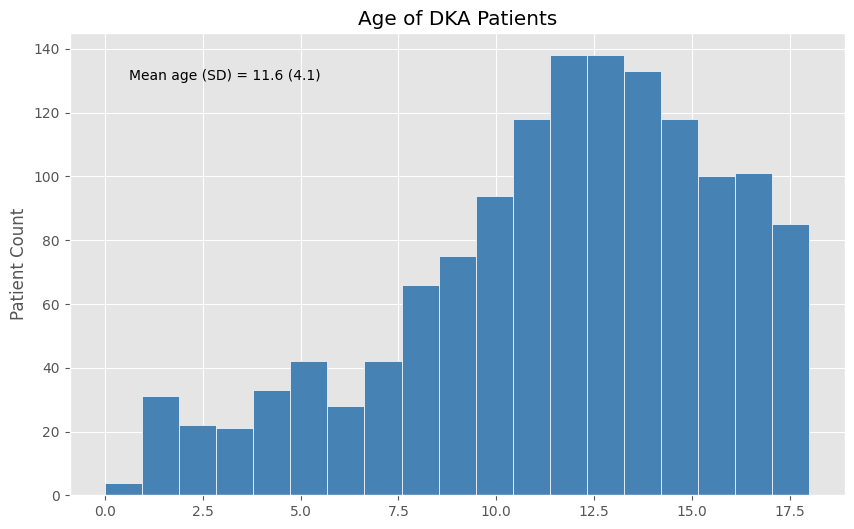

In [30]:
#histogram for age
fig = plt.figure(figsize = (10,6))

fig, ax = plt.subplots()
ax.hist(df_demo['Age'],
        bins = 19,
        range = (0,18),
                color = 'steelblue',
       edgecolor = 'white') 
ax.set_title("Age of DKA Patients")
ax.set_ylabel("Patient Count")
ax.text(0.2, 0.9, "Mean age (SD) = 11.6 (4.1)", fontsize=10, ha="center", transform=ax.transAxes)

plt.show()

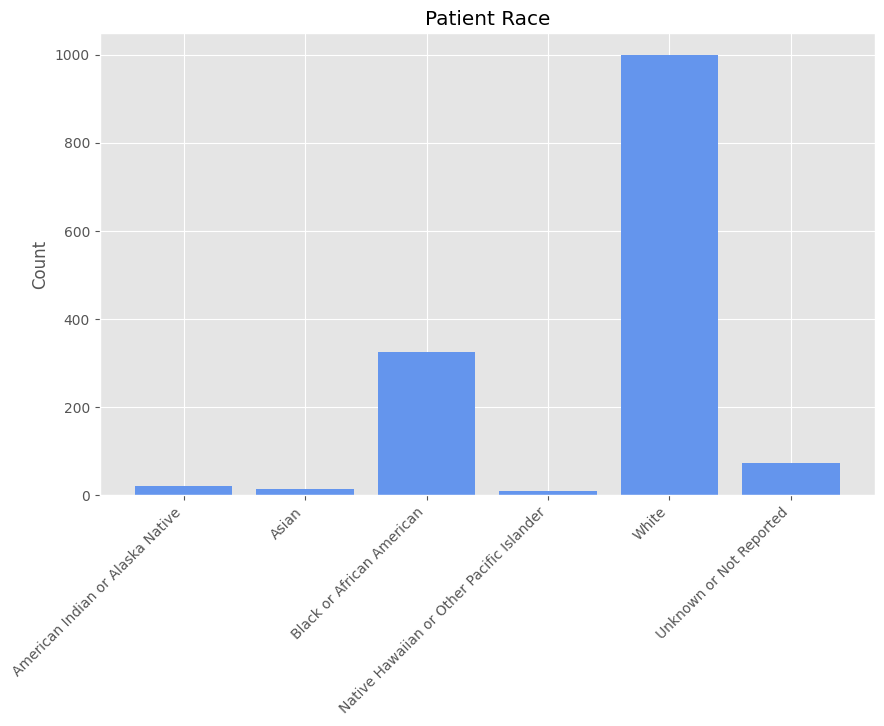

In [31]:
#create race counts

#subset dataframe for just race columns
race_counts = df_demo[['American Indian or Alaska Native', 'Asian', 'Black or African American', 'Native Hawaiian or Other Pacific Islander',
'White','Unknown or Not Reported']].sum()

fig, ax = plt.subplots(figsize = (10,6))
ax.bar(race_counts.index, race_counts.values,
                color = 'cornflowerblue')
       
ax.set_title("Patient Race")
ax.set_ylabel("Count")
plt.xticks(rotation = 45, ha = 'right')

plt.show()

In [32]:
#HEENT

# #Create Dry_MM column
# df['HEENT_DryMM'] = 0

# # #Apply sequential filters
# df.loc[df['PEHEENTDesc'].str.contains('dry muc', case=False, na=False), 'HEENT_DryMM'] = 1
# df.loc[df['PEHEENTDesc'].str.contains('drymm', case=False, na=False), 'HEENT_DryMM'] = 1
# df.loc[df['PEHEENTDesc'].str.contains('dry lip', case=False, na=False), 'HEENT_DryMM'] = 1


# #print(df[df['PEHEENTDesc'].str.contains("dry mucous", case = False, na = False)])
# # df.dtypes
# df.head(20)

#Cardio

#Create tachycardio column
df['Cardio_Tachy'] = 0

#Apply sequential filters
df.loc[df['PECardioDesc'] == 'tachycardic', 'Cardio_Tachy'] = 1
df.loc[df['PECardioDesc'] == 'tachycardia', 'Cardio_Tachy'] = 1
df.loc[df['PECardioDesc'].str.contains('tachycardic', case=False, na=False), 'Cardio_Tachy'] = 1
df.loc[df['PECardioDesc'].str.contains('tachycardia', case=False, na=False), 'Cardio_Tachy'] = 1

# df.dtypes
df.head(20)

##Resp 

#Create tachypnea column
df['Resp_Tachy'] = 0

#Create Kussmaul
df['Resp_Kuss'] = 0

#Apply sequential filters to resp_tachy
df.loc[df['PERespDesc'] == 'tachypnea', 'Resp_Tachy'] = 1
df.loc[df['PERespDesc'] == 'tachycardia', 'Resp_Tachy'] = 1

#Apply sequential filters to resp_kuss
#df.loc[df['PERespDesc'] == 'Kussmaul', 'Resp_Kuss'] = 1
df.loc[df['PERespDesc'].str.contains('Kuss', case=False, na=False), 'Resp_Kuss'] = 1

df.head(10)

##GI 

#Create abdominal pain column
df['GI_Pain'] = 0

#Create Kussmaul
df[''] = 0